# Data preparation

Spatial data has been fetched from the Humanitarian Data Exchange. \
Buildings: https://data.humdata.org/dataset/hotosm_uga_buildings \
Roads: https://data.humdata.org/dataset/hotosm_uga_roads \
Refugee camps: https://data.humdata.org/dataset/hotosm_uga_rr_refugee_camps \
\
All data is provided on a national level, and will thus have to be tailored to the needs of this research. The aim of this data preparation document is to be transparent on the steps conducted leading to the data files feeding into the model.\
\
Globally, the following steps have been conducted: filtering the buildings and the roads on the locations of interest, building datasets for the optimisation model, building and verifying datasets for the agent-based model.


In [232]:
# The libraries used 
import geopandas
import pandas as pd
import matplotlib.pyplot as plt

from data_prep_funcs import get_polygon_extremes
import math
import random
import numpy as np

## Selecting the main polygon and subzone polygons
The Shapefile as fetched from HDX contains all refugee camps and all their administrative subzones in the entire country of Uganda. Since we're only interested in the Bidi Bidi settlement and its administrative subzones, we select the polygon (a spatial data entry, covering a certain area) and match its administrative subzones. All data is plotted in order to visualise the steps taken. 

Extreme distance is  51.46549330180716


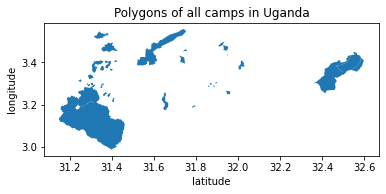

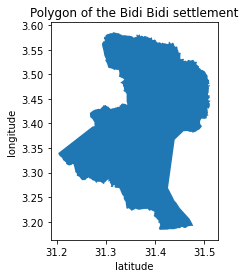

In [235]:
# Load and plot the polygon of all camps in Uganda
all_camps = geopandas.read_file("../input_files/adm_boundaries/hotosm_uga_rr_refugee_camps_polygons.shp")
all_camps.plot()
plt.title("Polygons of all camps in Uganda")
plt.xlabel("latitude")
plt.ylabel("longitude")

# Load and plot the BidiBidi polygon
bidibidi = geopandas.read_file("../input_files/adm_boundaries/camp_polygon.shp")
bidibidi.plot()
plt.title("Polygon of the Bidi Bidi settlement")
plt.xlabel("latitude")
plt.ylabel("longitude")

# introduce function for computing distance based on coordinates
def compute_distance(lata,latb,lona,lonb):
    R = 6373

    lata = math.radians(lata)
    lona = math.radians(lona)
    latb = math.radians(latb)
    lonb = math.radians(lonb)

    dlat = lata-latb
    dlon = lona-lonb

    a = math.sin(dlat / 2)**2 + math.cos(lata) * math.cos(latb) * math.sin(dlon / 2)**2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R*c

    return distance
extremes = get_polygon_extremes(bidibidi.geometry[0])

# compute extreme point to extreme point distance 
distance = compute_distance(extremes[0][0],extremes[0][1],extremes[1][0],extremes[1][1])
print("Extreme distance is ",distance)

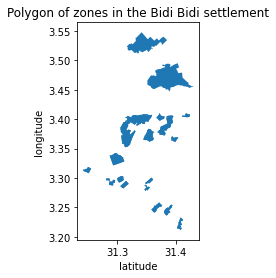

In [237]:
# spatial join of administrative zones within the Bidi Bidi settlement 
all_zones = geopandas.sjoin(all_camps,bidibidi,op='within')
all_zones = all_zones.drop(columns=["index_right"]) # drop a column
all_zones.plot()
plt.title("Polygon of zones in the Bidi Bidi settlement");
plt.xlabel("latitude");
plt.ylabel("longitude");

## Selecting buildings of interest
We use the administrative zones to determine which buildings are of interest. To do this, the geopandas.sjoin function is used. 

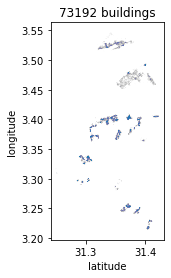

In [238]:
# # Spatial join, plot and count of the buildings within the zones' perimeters 
# all_zones_joined = geopandas.sjoin(buildings_in_district,all_zones)
# all_zones_joined.to_file("../input_files/building_polygons/all_zones.shp")

# Reading, plotting and counting the buildings within the camp's perimeters 
buildings_in_district = geopandas.read_file("../input_files/building_polygons/all_zones.shp")
buildings_in_district.plot()
plt.title("%s buildings"%len(buildings_in_district));
plt.xlabel("latitude");
plt.ylabel("longitude");

Separate GDFs are created for every zone and some information is printed

In [117]:
# Create separate geodataframes for every zone 
for zindex in range(1,6): 
    tmp_gdf = all_zones[all_zones.name == "Zone 0%s"%zindex]
    joined_tmp = geopandas.sjoin(buildings_in_district, tmp_gdf);
    joined_tmp.to_file("../input_files/building_polygons/per_zone/zone_%s.shp"%zindex);

In [118]:
# Count and list the number of buildings per zone 
for index in range(1,6): 
    tmp = geopandas.read_file("../input_files/building_polygons/per_zone/zone_%s.shp"%index)
    print("Zone ",index," counts ",len(tmp)," buildings")

Zone  1  counts  13134  buildings
Zone  2  counts  10148  buildings
Zone  3  counts  25096  buildings
Zone  4  counts  8276  buildings
Zone  5  counts  16538  buildings


GDFs tend to be relatively slow when information is fetched from them. Hence, the GDF is converted into a regular Pandas DataFrame to facilitate faster accessing by the optimisation model.

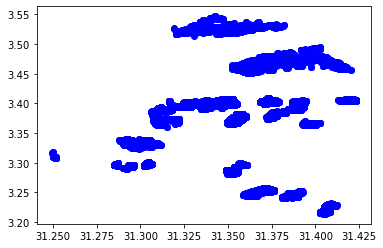

In [7]:
from data_prep_funcs import buildings_shp_to_df
import matplotlib.pyplot as plt

buildings_df = buildings_shp_to_df(address_of_shp="../input_files/building_polygons/all_zones.shp")
buildings_df.to_csv("save_files/buildings_all_zones_df.csv")

for i in range(len(buildings_df)):
    plt.plot(buildings_df.x[i],buildings_df.y[i],'bo')

## Selecting roads of interest
The same reasoning is valid for roads: we only select the roads that fall within the selected administrative zones. 

Text(129.49443164270627, 0.5, 'Longitude')

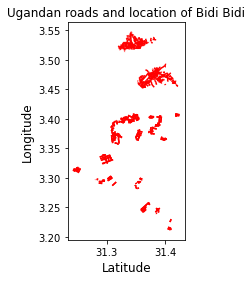

In [123]:
from data_prep_funcs import roads_within_polygon
import seaborn 

roads_intersect, roads_within = roads_within_polygon(address_of_road_shp="../input_files/roads/hotosm_uga_roads_lines.shp",
                                                      polygon=all_zones)
seaborn.set_context( rc={"axes.labelsize":12})
fig,ax = plt.subplots()
roads_within.plot(ax=ax,color='red')
plt.title("Ugandan roads and location of Bidi Bidi")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

In [4]:
# Save the results from joining roads to the zone polygons
roads_intersect.to_file("../input_files/roads/roads_all_zones_intersect.shp")
roads_within.to_file("../input_files/roads/roads_all_zones_within.shp")

NameError: name 'roads_intersect' is not defined

## Making a road-acess grid
The optimisation model aims to find an optimal placement for facilities, but not all locations provide appropriate infrastructure. The proximity of a road is thought to be a good proxy for the availability of such infrastructure.\
\
The camp is subdivided in a grid where the presence of a road proxy-indicates the appropriateness of a location. This idea is visually represented in a heatmap. 

Cell size is  2.2961526342484766  km


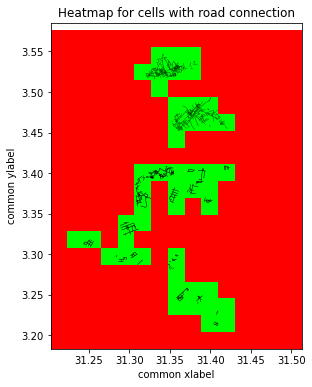

In [25]:
from data_prep_funcs import make_road_heatmap
import geopandas

roads_within = geopandas.read_file("../input_files/roads/roads_all_zones_within.shp")

def make_road_heatmap2(grid_gdf,
                      roads_shp,
                      extr_x,
                      extr_y,
                      x_steps):
    import seaborn
    import geoplot
    import geopandas
    import math
    import matplotlib.pyplot as plt
    import numpy as np
    
    def compute_cell_size(extr_x=extr_x,extr_y=extr_y,number_of_steps=x_steps):

        # approximate radius of earth in km
        R = 6373.0

        lat1 = math.radians(extr_y[0])
        lon1 = math.radians(extr_x[0])
        lat2 = math.radians(extr_y[0])
        lon2 = math.radians(extr_x[0]+(extr_x[1]-extr_x[0])/number_of_steps)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = math.sin(dlat / 2)**2 + math.cos(lat1) *math.cos(lat2) * math.sin(dlon / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        distance = R * c

        print("Cell size is ", distance," km")

    compute_cell_size()
    dims = (10, 6) # define dimensions tuple
    fig,ax = plt.subplots(1,1,figsize=dims) # Define figurex axis for subplots and dimensions

    # Set common labels
    ax.set_xlabel('common xlabel')
    ax.set_ylabel('common ylabel')

    
    plt.xlim([extr_x[0],extr_x[1]]) # set xlim
    plt.ylim([extr_y[0],extr_y[1]]) # set ylim
    plt.title('Impression of tiles with r') # set title

    for i in grid_gdf.index:
        grid_gdf.loc[[i],'geometry'].plot(ax=ax,color=(1-grid_gdf.roads[i],(1+grid_gdf.roads[i])-1,0))
    
    #geoplot.choropleth(grid_gdf,ax=ax,hue=grid_gdf['roads'],legend=True,cmap='RdYlGn') # draw heatmap
    roads_shp.plot(ax=ax,color='black',lw=0.3) # draw roads

make_road_heatmap2(grid_gdf=grid_gdf,
                      roads_shp=roads_within,
                      extr_x=extr_x,
                      extr_y=extr_y,
                      x_steps=x_steps)



## Scaling down the number of buildings
If the ABM were to be implemented on a full scale, every building is initialised as one household. With a population of 232,743 and a household size averaging 7 (Butele, 2017), the list of buildings counts 33,249 buildings.\
\
The number of buildings in the filtered GDF is 73,129, which does not correspond with the conceptualised number. Scaling down to 33k still implies a very significant computational load. It is thought that a number of 2k agents will bring the computational expense of the model down to an acceptable level. In order to verify the influence of scaling on model behaviour, 4 GDFs are created with 33k as reference: 5, 11, 15, with a size of 7k, 3k and 2k. 

In [132]:
densities = list()

for z in all_zones.index:
    a = (all_zones.geometry[z].area)
    
    b = len(buildings_in_district[buildings_in_district.osm_id==all_zones.osm_id[z]])
    
    densities.append(b/a)

densities_original = densities

Number of buildings counts  33249.0


Scaling down to 33,249 agents does not change the average density per zone a lot. 

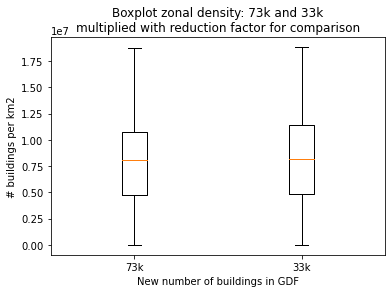

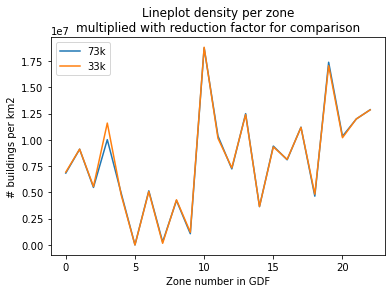

In [231]:
# Used as the default size

newlen = 33249
# l=list()
# for i in range(len(buildings_in_district)):
#     if newlen<random.uniform(0,1)*73192:
#         l.append(i)
# buildings_in_district_short = buildings_in_district.drop(l)
# buildings_in_district_short.to_file("../input_files/building_polygons/filtered/33249.shp")

buildings_in_district_short = geopandas.read_file("../input_files/building_polygons/filtered/33249.shp")
        
densities = list()

for z in all_zones.index:
    a = (all_zones.geometry[z].area)
    
    b = len(buildings_in_district_short[buildings_in_district_short.osm_id==all_zones.osm_id[z]])
    
    c = b/a * len(buildings_in_district)/len(buildings_in_district_short)
    
    densities.append(c)

densities_33k = densities

fig, ax = plt.subplots()
ax.boxplot([densities_original,densities_33k])

plt.xticks([1,2],["73k","33k"]);
plt.title("Boxplot zonal density: 73k and 33k\nmultiplied with reduction factor for comparison");
plt.xlabel("New number of buildings in GDF");
plt.ylabel("# buildings per km2");

plt.show()


plt.plot(densities_original);
plt.plot(densities_33k);
plt.legend(["73k","33k"]);

plt.title("Lineplot density per zone\nmultiplied with reduction factor for comparison");
plt.xlabel("Zone number in GDF");
plt.ylabel("# buildings per km2");

A scaling factor of 5 leads to more variation as a consequence of random scaling. 

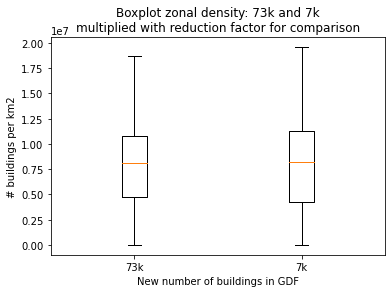

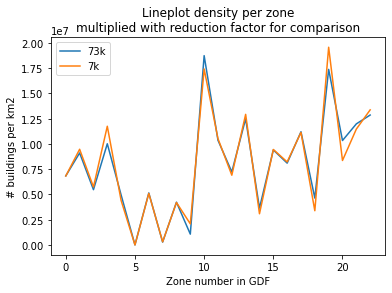

In [229]:
newlen = 6650
# l=list()
# for i in range(len(buildings_in_district)):
#     if newlen<random.uniform(0,1)*73192:
#         l.append(i)
# buildings_in_district_short = buildings_in_district.drop(l)
# buildings_in_district_short.to_file("../input_files/building_polygons/filtered/6650.shp")

buildings_in_district_short = geopandas.read_file("../input_files/building_polygons/filtered/6650.shp")
        
densities = list()

for z in all_zones.index:
    a = (all_zones.geometry[z].area)
    
    b = len(buildings_in_district_short[buildings_in_district_short.osm_id==all_zones.osm_id[z]])
    
    c = b/a * len(buildings_in_district)/len(buildings_in_district_short)
    
    densities.append(c)
    
densities_7k = densities

fig, ax = plt.subplots()
ax.boxplot([densities_original,densities_7k])

plt.xticks([1,2],["73k","7k"]);
plt.title("Boxplot zonal density: 73k and 7k\nmultiplied with reduction factor for comparison");
plt.xlabel("New number of buildings in GDF");
plt.ylabel("# buildings per km2");

plt.show()


plt.plot(densities_original);
plt.plot(densities_7k);
plt.legend(["73k","7k"]);

plt.title("Lineplot density per zone\nmultiplied with reduction factor for comparison");
plt.xlabel("Zone number in GDF");
plt.ylabel("# buildings per km2");

A scaling factor of 11 increases the variation even more. 

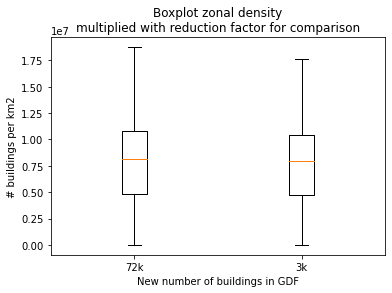

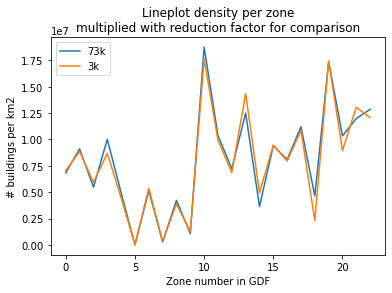

In [228]:
newlen = 3022
# l=list()
# for i in range(len(buildings_in_district)):
#     if newlen<random.uniform(0,1)*73192:
#         l.append(i)
# buildings_in_district_short = buildings_in_district.drop(l)
# buildings_in_district_short.to_file("../input_files/building_polygons/filtered/3022.shp")

buildings_in_district_short = geopandas.read_file("../input_files/building_polygons/filtered/3022.shp")
        
densities = list()

for z in all_zones.index:
    a = (all_zones.geometry[z].area)
    
    b = len(buildings_in_district_short[buildings_in_district_short.osm_id==all_zones.osm_id[z]])
    
    c = b/a * len(buildings_in_district)/len(buildings_in_district_short)
    
    densities.append(c)
densities_3k = densities


fig, ax = plt.subplots()
ax.boxplot([densities_original,densities_3k])

plt.xticks([1,2],["73k","3k"]);
plt.title("Boxplot zonal density: 73k and 3k\nmultiplied with reduction factor for comparison");
plt.xlabel("New number of buildings in GDF");
plt.ylabel("# buildings per km2");

plt.show()


plt.plot(densities_original);
plt.plot(densities_3k);
plt.legend(["73k","3k"]);

plt.title("Lineplot density per zone\nmultiplied with reduction factor for comparison");
plt.xlabel("Zone number in GDF");
plt.ylabel("# buildings per km2");

And lastly a scaling factor of 15 even more, according to expectation

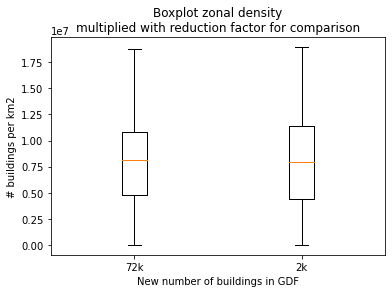

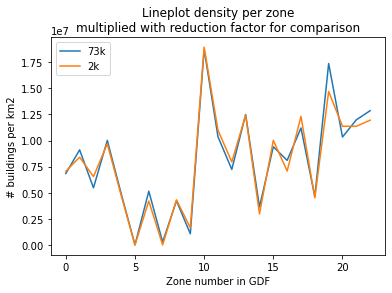

In [227]:
newlen = 2217

# l=list()
# for i in range(len(buildings_in_district)):
#     if newlen<random.uniform(0,1)*73192:
#         l.append(i)
# buildings_in_district_short = buildings_in_district.drop(l)
# buildings_in_district_short.to_file("../input_files/building_polygons/filtered/2217.shp")

buildings_in_district_short = geopandas.read_file("../input_files/building_polygons/filtered/2217.shp")
        
densities = list()

for z in all_zones.index:
    a = (all_zones.geometry[z].area)
    
    b = len(buildings_in_district_short[buildings_in_district_short.osm_id==all_zones.osm_id[z]])
    
    c = b/a * len(buildings_in_district)/len(buildings_in_district_short)
    
    densities.append(c)
densities_2k = densities


fig, ax = plt.subplots()
ax.boxplot([densities_original,densities_2k])

plt.xticks([1,2],["73k","2k"]);
plt.title("Boxplot zonal density: 73k and 2k\nmultiplied with reduction factor for comparison");
plt.xlabel("New number of buildings in GDF");
plt.ylabel("# buildings per km2");

plt.show()


plt.plot(densities_original);
plt.plot(densities_2k);
plt.legend(["73k","2k"]);

plt.title("Lineplot density per zone\nmultiplied with reduction factor for comparison");
plt.xlabel("Zone number in GDF");
plt.ylabel("# buildings per km2");

A final boxplot of the densities per is made and we can observe that the general pattern remains more or less stable. For very exact measurements, this approach may not be suited very well, but recall the highly uncertain nature of the spatial distribution of people. This data merely serves as a concrete example of how things might be, rather than the exact representation of their spatial distribution. 

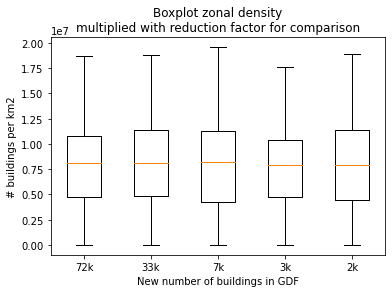

In [221]:
fig, ax = plt.subplots()
ax.boxplot([densities_original,densities_33k,densities_7k,densities_3k,densities_2k])
plt.xticks([1,2,3,4,5],["73k","33k","7k","3k","2k"])
plt.title("Boxplot zonal density\nmultiplied with reduction factor for comparison")
plt.xlabel("New number of buildings in GDF")
plt.ylabel("# buildings per km2")
plt.show()

## Distances between facilities and buildings
In order to check the proposals for scaling and their implications for the model, one has to have a good idea of the order of magnitude of things. Here, a boxplot is presented of how close people live to a facility. 

25th percentile is  0.551447817438278
10th percentile is  0.23006919997897787
Mean is  1.2665279136558103


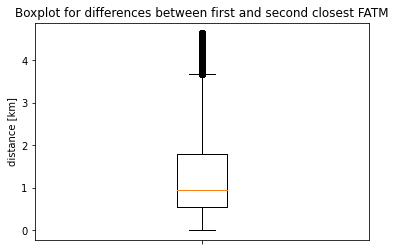

In [240]:
ob = pd.read_csv("save_files/ob_init2.csv").iloc[:,1:]
var = pd.read_csv("save_files/var_init2.csv").iloc[:,1:]

buildings_df = pd.read_csv("save_files/buildings_all_zones_df.csv")

# A little workaround to get to the right string 
most_eq_colname = var.columns[ob.iloc[3,:]==np.min(ob.iloc[3,:])][0]
equal_vars = var[most_eq_colname]

# Initialise and fill both container for x-y coords
fac_x_list = list() # x coords per facility
fac_y_list = list() # y coords per facility
for a in range(len(equal_vars)):
    if a%2==0:
        fac_x_list.append(equal_vars[a])
    else:
        fac_y_list.append(equal_vars[a])

# Emtpy containers for ppl per facility, distance per building resp.
fac_nb = np.zeros(int(len(equal_vars)/2))
dist_b = np.zeros(len(buildings_df))
dist_b2 = np.zeros(len(buildings_df))

# Fill in the containers
for b in range(len(buildings_df)):

    b_x = buildings_df.x[b]
    b_y = buildings_df.y[b]
    min_distance = np.inf
    min_distance2 = np.inf

    for f in range(len(fac_x_list)):
        fac_x = fac_x_list[f]
        fac_y = fac_y_list[f]

        # tmp_distance = np.sqrt( ( (b_x-fac_x)**2 + (b_y-fac_y)**2 ) )
        tmp_distance = compute_distance(b_x,fac_x,b_y,fac_y)

        if tmp_distance<min_distance2:
            min_distance2=tmp_distance
            if tmp_distance<min_distance:
                min_distance2=min_distance
                min_distance=tmp_distance
                closest_fac = f

        else:
            pass

    fac_nb[closest_fac] += 1
    dist_b[b] = min_distance
    dist_b2[b] = min_distance2

dist_differences = dist_b2 - dist_b  
plt.boxplot(dist_differences);
plt.title("Boxplot for differences between first and second closest FATM");
plt.ylabel("distance [km]");
plt.xticks([1],[])
print("25th percentile is ",np.percentile(dist_differences,25))
print("10th percentile is ",np.percentile(dist_differences,10))
print("Mean is ",np.mean(dist_differences))


25th percentile is  1.1517488629815191
10th percentile is  0.651633687839824
Mean is  1.8032700232724124


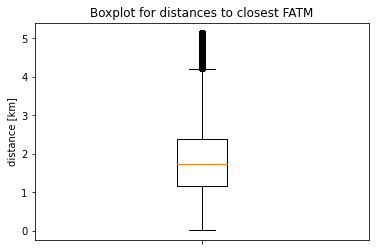

In [241]:
plt.boxplot(dist_b);
plt.title("Boxplot for distances to closest FATM");
plt.ylabel("distance [km]");
plt.xticks([1],[]);
print("25th percentile is ",np.percentile(dist_b,25))
print("10th percentile is ",np.percentile(dist_b,10))
print("Mean is ",np.mean(dist_b))